In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from  sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

training_df = pd.read_csv("./training.csv")

training_df.fillna(0, inplace=True)
training_df.drop(['date', 'month'], axis=1, inplace=True) 

X = training_df.drop('fire', axis=1)
y = training_df['fire']

In [65]:
"""
Standard Scaling for the numerical variables cause every column is in different units - Centigrade, centimeter, millimeter etc
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_transformation(encode_df):
    num_attributes=encode_df.columns.to_list()
    numeric_pipeline=Pipeline([
        ('std_scaler',StandardScaler())
    ])
    encoder_pipeline=ColumnTransformer([
        ("numeric_var",numeric_pipeline,num_attributes),
    ])
    df_encoded=encoder_pipeline.fit_transform(encode_df)
    return df_encoded,encoder_pipeline
X_transformed=feature_transformation(X)[0]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [ ]:

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_dt = grid_search.best_estimator_

print("Best parameters found:", best_params)

y_pred = best_dt.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy on test data: 0.7488871798457201
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73     21432
           1       0.72      0.82      0.77     21477

    accuracy                           0.75     42909
   macro avg       0.75      0.75      0.75     42909
weighted avg       0.75      0.75      0.75     42909

Confusion Matrix:
[[14500  6932]
 [ 3843 17634]]


In [68]:
"""
Built a random forest model and displayed the best features based on Gini Importance
"""
importances = best_dt.feature_importances_
feature_names=X.columns
feature_imp_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
15,et0_fao_evapotranspiration,0.202099
22,soil_temperature_0_to_7cm,0.072948
23,soil_temperature_7_to_28cm,0.055787
9,pressure_msl,0.051572
18,wind_speed_100m,0.051067
1,relative_humidity_2m,0.047894
24,soil_temperature_28_to_100cm,0.046238
3,apparent_temperature,0.040824
16,vapour_pressure_deficit,0.039915
2,dew_point_2m,0.034218


In [69]:
"""
Analytically - The features with lower importance involve cloud cover, weather code, rain, snow.
Intuitively - You would expect rain, snow, weather code or cloud cover to have an effect on fire
"""
unimportant_features=feature_imp_df[feature_imp_df['Gini Importance']<(2/100)]['Feature'].tolist()

In [70]:
"""
This is an optional step because since we have only about 31 features, the only advantage of dropping features that are highly correlated is the increase in model building time
and not really the accuracy as seen below in the evaluation metrics. The AUC scores are pretty much the same
"""
high_correlated_features=['soil_temperature_7_to_28cm','wind_direction_10m','temperature_2m','soil_moisture_28_to_100cm',
                          'soil_moisture_7_to_28cm','soil_temperature_100_to_255cm','soil_temperature_28_to_100cm',
                          'soil_temperature_100_to_255cm','soil_moisture_100_to_255cm']

In [71]:
drop_features=unimportant_features+high_correlated_features
X.drop(drop_features,axis=1,inplace=True)
X.shape

(214545, 13)

In [72]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [ ]:

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_dt = grid_search.best_estimator_

print("Best parameters found:", best_params)

y_pred = best_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy on test data: 0.741918944743527
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72     21432
           1       0.71      0.81      0.76     21477

    accuracy                           0.74     42909
   macro avg       0.75      0.74      0.74     42909
weighted avg       0.75      0.74      0.74     42909

Confusion Matrix:
[[14444  6988]
 [ 4086 17391]]


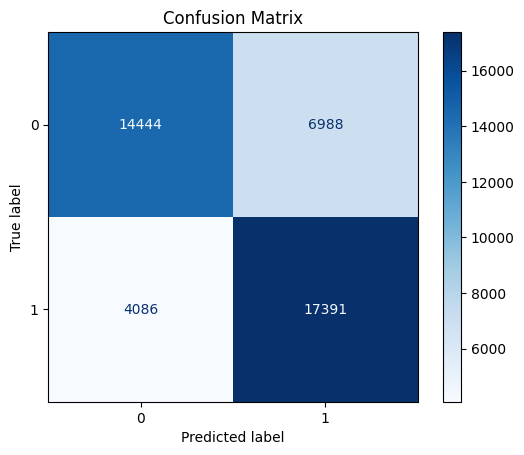

In [74]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

AUC-ROC Score: 0.7418477335659632


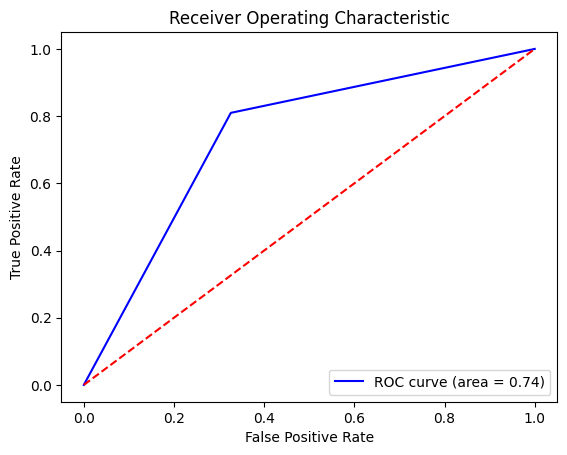

In [ ]:
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-ROC Score:", auc_score)


fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()